# 7. GPrune with Dengue Data

## Setup

In [51]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow as gpf
import tensorflow as tf

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## GPrune

In [52]:
def GPrune (model, X, y, init_kernel, selection_threshold = 0.1, alpha_range = [0.001, 0.01, 0.1, 1.0], max_iter = 10, verbose = 1):
    """ 
    Alternates between Lasso-based feature selection and Gaussian Process optimization.

    Runs an iterative loop that uses LassoCV to select relevant input features, then updates the kernel of GP model to use only those features. 
    The loop stops when feature selection and mean function coefficients converge, or when the maximum number of iterations is reached

    Parameters:
    ----------
        model: gpflow.models.GPR
            The GP model to optimize. 
        X: tf.Tensor or np.ndarray
            Input features
        y: tf.Tensor or np.ndarray
            Target values
        init_kernel: gpflow.kernels.Kernel
            The initial GP kernel
        selection_threshold: float, optional
            Threshold value for feature selection. Default is 0.1
        alpha_range: list
            Range of alphas to cross-validate over. Default is [0.01, 0.1, 1.0].
        max_iter: int, optional
            Maximum number of alternating iterations. Default is 10
        verbose: bool, optional
            Will show output. Default is 1

    Returns:
    -------
        model: gpflow.models.GPR
            The optimized GP model
    
    """

    X_current = X
    m = X_current.shape[1]
    current_kernel = init_kernel
    active_dims = list(range(X.shape[1]))
    count = 0
    tol = 1e-6

    while True:

        count += 1

        alt_las = LassoCV(alphas=alpha_range)
        alt_las.fit(X_current, y.reshape(-1))
        
        if verbose:
            print(f"\n --- Beginning Iteration {count} --- ")
            print(f'Lasso Best Alpha: {alt_las.alpha_:.3f}')
            print(f'Lasso Coefficients: {alt_las.coef_}')

        # Threshold and select features
        select_mask = np.abs(alt_las.coef_) >= selection_threshold

        if not np.any(select_mask):
            if verbose:
                print(f"No features selected at threshold {selection_threshold}. Skipping.")
            return model


        prev_active_dims = active_dims # save old value

        active_dims = np.where(select_mask)[0].tolist() # set new value

        if verbose:
            print(f'Selected Features: {select_mask}')
            print('active dims', active_dims)

        # Update X_current
        X_current = X_current[:, active_dims]

        # Update m
        m = X_current.shape[1]

        # Update kernel
        model.kernel = gpf.kernels.SquaredExponential(
            lengthscales = np.ones(len(active_dims)),
            active_dims=list(range(m))
        )
        
        # Optimize
        prev_A = model.mean_function.A # store old values
        opt.minimize(model.training_loss, model.trainable_variables)
        current_A = model.mean_function.A # set new values


        if count >= max_iter:
            print('Too Many Iterations')
            break

        # stop when active dimensions and linear weights stabilize, 
        if active_dims == prev_active_dims and tf.reduce_max(tf.abs(current_A - prev_A)) < tol:
            if verbose:
                print(f"\n ! Converged on iteration {count} ! ")
            break

    return model

## Utility Functions

In [3]:
def reset_data(numtrain, numtest, res_var, df = False): 
    """
    Loads and preprocesses simulation data, returning train/test sets for a selected response variable.

    Parameters
    ----------
    numtrain : int
        Number of samples to draw from the training set.
    numtest : int
        Number of samples to draw from the test set.
    res_var : str
        The name of the response variable to keep. Must be one of:
        ['log duration', 'duration', 'epidemicSize', 'maxIncidence',
         'sd_maxIncidence', 'sd_epidemicSize', 'sd_duration'].
    df : bool, optional
        If True, return results as DataFrames. If False, return NumPy arrays (default: False).

    Returns
    -------
    Xtrain, Xtest, Ytrain, Ytest : tuple
        Either NumPy arrays or Pandas DataFrames depending on `df`.
        - Xtrain: Training inputs
        - Xtest: Test inputs
        - Ytrain: Training targets
        - Ytest: Test targets
    """

    # read data
    train_set = pd.read_csv(train_path, sep = "\t")
    test_set = pd.read_csv(test_path, sep = "\t")

    # take log of duration
    train_set['log duration'] = np.log(train_set['duration'])  
    test_set['log duration'] = np.log(test_set['duration'])

    # drop unnecessary columns
    drop_cols = [ 'simRound', 'simID']

    possible_response_vars = ['log duration', 'duration', 'epidemicSize', 'maxIncidence','sd_maxIncidence', 'sd_epidemicSize', 'sd_duration']

    for item in possible_response_vars:
        if item != res_var:
           drop_cols.append(item)

    train_set = train_set.drop(drop_cols, axis=1)
    test_set = test_set.drop(drop_cols, axis=1)

    # size check
    numtrain = min(numtrain, len(train_set))
    numtest = min(numtest, len(test_set))

    # select random n points
    train_subset = train_set.sample(n=numtrain, random_state=22)
    Xtrain_df = train_subset.drop(res_var, axis=1)
    Xtrain = Xtrain_df.to_numpy()
    Ytrain_df = train_subset[res_var]
    Ytrain = Ytrain_df.to_numpy().reshape(-1, 1)

    test_subset = test_set.sample(n=numtest, random_state=22)
    Xtest_df = test_subset.drop(res_var, axis=1)
    Xtest = Xtest_df.to_numpy()
    Ytest_df = test_subset[res_var]
    Ytest = Ytest_df.to_numpy().reshape(-1, 1)

    if df:
        return Xtrain_df, Xtest_df, Ytrain_df, Ytest_df
    else:
        return Xtrain, Xtest, Ytrain, Ytest

## Using GPrune on Dengue Data

In [53]:
train_path = "/Users/liviafingerson/Desktop/IEMS399/Dengue/Data/Simulation/Duration/DD-AML-train-LHS-5000-condSim-logDuration.txt"
test_path = "/Users/liviafingerson/Desktop/IEMS399/Dengue/Data/Simulation/Duration/DD-AML-test-LHS-10000-condSim-logDuration.txt"

In [54]:
Xtrain_unscaled, Xtest_unscaled, ytrain, ytest = reset_data(numtrain = 500, numtest = 100, res_var = 'maxIncidence')

# make sure we scale data
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain_unscaled)
Xtest = scaler.transform(Xtest_unscaled)
ytrain = ytrain.reshape(-1,1)


m = Xtrain.shape[1]

In [55]:
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)

kernel = gpf.kernels.SquaredExponential(lengthscales=np.ones(m))
likelihood = gpf.likelihoods.Gaussian()
mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

opt = gpf.optimizers.Scipy()

In [56]:
# creating a baseline model

baseline_mod = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )
opt.minimize(baseline_mod.training_loss, baseline_mod.trainable_variables)

baseline_mod

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(8, 1)",float64,[[0.23874615...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.19513218]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.09985245573177673
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[1.63621, 3.8437, 0.7068419..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.002824771177988797


In [57]:
dengue_mod_pruned = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )

dengue_mod_pruned = GPrune(model = dengue_mod_pruned, X = Xtrain, y = ytrain, init_kernel = gpf.kernels.SquaredExponential(lengthscales=np.ones(m)), selection_threshold = 0.05)


 --- Beginning Iteration 1 --- 
Lasso Best Alpha: 0.001
Lasso Coefficients: [ 0.16222232 -0.0131597  -0.03553205  0.04557162  0.14920937  0.00063826
 -0.05156649  0.00709328]
Selected Features: [ True False False False  True False  True False]
active dims [0, 4, 6]

 --- Beginning Iteration 2 --- 
Lasso Best Alpha: 0.001
Lasso Coefficients: [ 0.15958565  0.14740047 -0.05066581]
Selected Features: [ True  True  True]
active dims [0, 1, 2]

 --- Beginning Iteration 3 --- 
Lasso Best Alpha: 0.001
Lasso Coefficients: [ 0.15958565  0.14740047 -0.05066581]
Selected Features: [ True  True  True]
active dims [0, 1, 2]

 ! Converged on iteration 3 ! 


In [58]:
# testing custom alpha range
alpha_range = np.logspace(-3, 0, 25)

dm2 = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )


dm2 = GPrune(model = dm2, X = Xtrain, y = ytrain, init_kernel = gpf.kernels.SquaredExponential(lengthscales=np.ones(m)), selection_threshold = 0.05, alpha_range = alpha_range)


 --- Beginning Iteration 1 --- 
Lasso Best Alpha: 0.001
Lasso Coefficients: [ 0.16185504 -0.01281751 -0.03519614  0.04519893  0.14883953  0.0003294
 -0.05121984  0.00674626]
Selected Features: [ True False False False  True False  True False]
active dims [0, 4, 6]

 --- Beginning Iteration 2 --- 
Lasso Best Alpha: 0.001
Lasso Coefficients: [ 0.15958565  0.14740047 -0.05066581]
Selected Features: [ True  True  True]
active dims [0, 1, 2]

 --- Beginning Iteration 3 --- 
Lasso Best Alpha: 0.001
Lasso Coefficients: [ 0.15958565  0.14740047 -0.05066581]
Selected Features: [ True  True  True]
active dims [0, 1, 2]

 ! Converged on iteration 3 ! 


## Visualizations

### Plotting Functions

In [28]:
def plot_threshold_sweep(Xtrain, ytrain, Xtest, ytest, thresholds, baseline_model):
    """
    Sweeps over different Lasso coefficient thresholds, applies GPrune,
    and plots RMSE (with baseline comparison).

    Parameters
    ----------
    Xtrain : array
        Training features.
    ytrain : array-like
        Training targets.
    Xtest : array
        Test features.
    ytest : array
        Test targets.
    thresholds : list or np.ndarray
        Thresholds to range over.
    baseline_model : gpflow.models.GPR
        A reference model to compare RMSE against.
    """

    r2_scores = []
    rmse_scores = []

    for thresh in thresholds:
        # initialize the model
        m = Xtrain.shape[1]
        model = gpf.models.GPR(
            data=(Xtrain, ytrain), 
            kernel=gpf.kernels.SquaredExponential(lengthscales=np.ones(m)), 
            mean_function=gpf.functions.Linear(
                A=tf.zeros((m, 1), dtype=tf.float64),
                b=tf.zeros((1,), dtype=tf.float64)
            )
        )

        # GPrune
        model = GPrune(
            model=model,
            X=Xtrain,
            y=ytrain,
            init_kernel=kernel,
            selection_threshold=thresh,
            verbose=0
        )

        # predict on test data
        y_pred, _ = model.predict_y(Xtest)
        
        # calculate scores
        r2_scores.append(r2_score(ytest, y_pred.numpy()))
        rmse_scores.append(np.sqrt(mean_squared_error(ytest, y_pred)))

    y_base, _ = baseline_model.predict_y(Xtest)
    baseline_rmse = np.sqrt(mean_squared_error(ytest, y_base.numpy()))

    plt.plot(thresholds, rmse_scores, marker = 'o')
    plt.axhline(y=baseline_rmse, color='red', linestyle='--', label='Baseline Model')
    plt.xlabel("Lasso Coefficient Threshold")
    plt.ylabel("Test RMSE Score")
    plt.title("Threshold vs GP Model Performance (RMSE)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Results

For max incidence

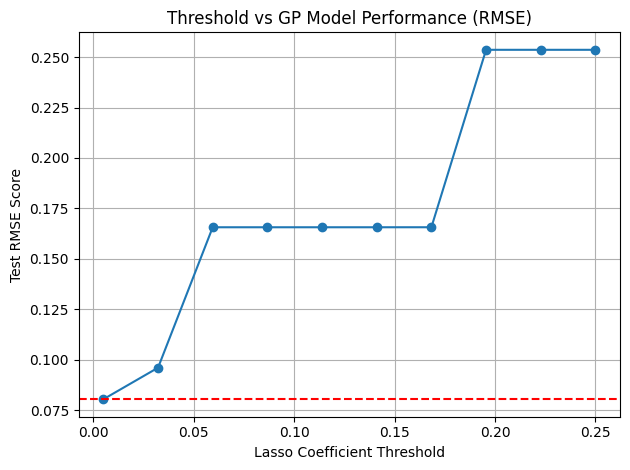

In [59]:
Xtrain_unscaled, Xtest_unscaled, ytrain, ytest = reset_data(numtrain = 800, numtest = 200, res_var = 'maxIncidence')

# make sure we scale data
Xtrain = scaler.fit_transform(Xtrain_unscaled)
Xtest = scaler.transform(Xtest_unscaled)

m = Xtrain.shape[1]
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)
base_mod = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=gpf.kernels.SquaredExponential(lengthscales=np.ones(m)), 
    likelihood = gpf.likelihoods.Gaussian(),
    mean_function = gpf.functions.Linear(A=A_init, b = b_init) 
    )

opt = gpf.optimizers.Scipy()
opt.minimize(base_mod.training_loss, base_mod.trainable_variables)

thresholds = np.linspace(0.005, 0.25, 10)

plot_threshold_sweep(Xtrain, ytrain, Xtest, ytest, thresholds, base_mod)

For epidemic size

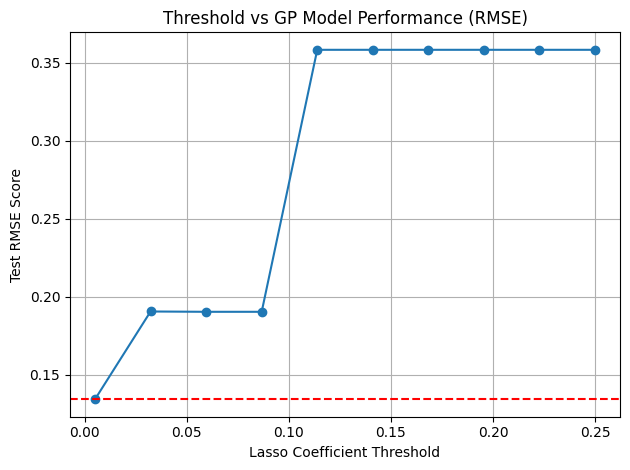

In [41]:
Xtrain_unscaled, Xtest_unscaled, ytrain, ytest = reset_data(numtrain = 800, numtest = 200, res_var = 'epidemicSize')

# make sure we scale data
Xtrain = scaler.fit_transform(Xtrain_unscaled)
Xtest = scaler.transform(Xtest_unscaled)

m = Xtrain.shape[1]
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)
base_mod = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=gpf.kernels.SquaredExponential(lengthscales=np.ones(m)), 
    likelihood = gpf.likelihoods.Gaussian(),
    mean_function = gpf.functions.Linear(A=A_init, b = b_init) 
    )

opt = gpf.optimizers.Scipy()
opt.minimize(base_mod.training_loss, base_mod.trainable_variables)

thresholds = np.linspace(0.005, 0.25, 10)

plot_threshold_sweep(Xtrain, ytrain, Xtest, ytest, thresholds, base_mod)

For log duration

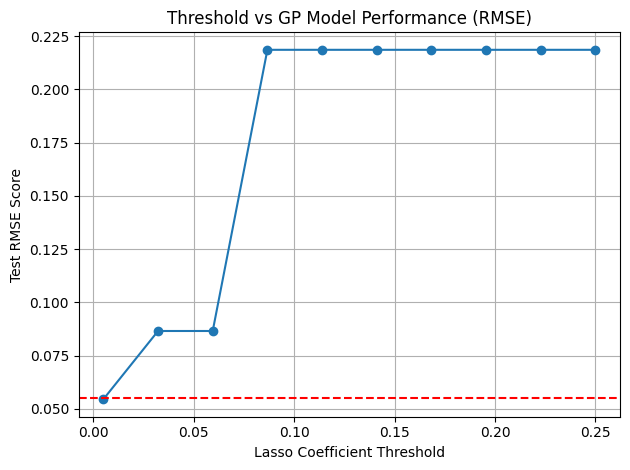

In [40]:
Xtrain_unscaled, Xtest_unscaled, ytrain, ytest = reset_data(numtrain = 800, numtest = 200, res_var = 'log duration')

# make sure we scale data
Xtrain = scaler.fit_transform(Xtrain_unscaled)
Xtest = scaler.transform(Xtest_unscaled)

m = Xtrain.shape[1]
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)
base_mod = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=gpf.kernels.SquaredExponential(lengthscales=np.ones(m)), 
    likelihood = gpf.likelihoods.Gaussian(),
    mean_function = gpf.functions.Linear(A=A_init, b = b_init) 
    )

opt = gpf.optimizers.Scipy()
opt.minimize(base_mod.training_loss, base_mod.trainable_variables)

thresholds = np.linspace(0.005, 0.25, 10)

plot_threshold_sweep(Xtrain, ytrain, Xtest, ytest, thresholds, base_mod)

Can I use a regular RBF Kernel, not ARD? 

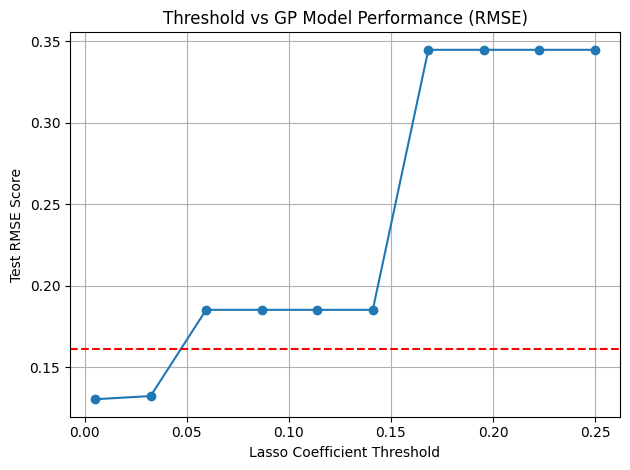

In [61]:
Xtrain_unscaled, Xtest_unscaled, ytrain, ytest = reset_data(numtrain = 200, numtest = 100, res_var = 'maxIncidence')

# make sure we scale data
Xtrain = scaler.fit_transform(Xtrain_unscaled)
Xtest = scaler.transform(Xtest_unscaled)

m = Xtrain.shape[1]
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)
base_mod = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=gpf.kernels.SquaredExponential(), 
    likelihood = gpf.likelihoods.Gaussian(),
    mean_function = gpf.functions.Linear(A=A_init, b = b_init) 
    )

opt = gpf.optimizers.Scipy()
opt.minimize(base_mod.training_loss, base_mod.trainable_variables)

thresholds = np.linspace(0.005, 0.25, 10)

plot_threshold_sweep(Xtrain, ytrain, Xtest, ytest, thresholds, base_mod)